In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader , Dataset
from sklearn.metrics import (mean_absolute_error,
                             mean_absolute_percentage_error,
                             mean_squared_error,
                             r2_score)
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer


In [2]:
dff = pd.read_csv("/content/sample_data/HomeDataset_after_preprocess_04_06.csv")
df = dff.dropna(axis=0)
x = df.drop(["price"] , axis=1)
y = df["price"]
device = "cuda" if torch.cuda.is_available() else "cpu"

# scaling data =>

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state= 42)

columns_to_scale = ['num_floor', 'unit_per_floor',  'age', 'statuse', 'view',
       'doc_status', 'floor', 'area',
       'num_sleep', 'kitch', 'service', 'floor_covering',
         'equipment', 'address_encoded',
       'room_to_area']
#scale the data
x_scaler = StandardScaler()
x_scaler.fit(x_train[columns_to_scale])
x_train[columns_to_scale] = x_scaler.transform(x_train[columns_to_scale])
x_test[columns_to_scale] = x_scaler.transform(x_test[columns_to_scale])


y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1,1))
y_test = y_scaler.transform(y_test.values.reshape(-1,1))


In [3]:
class ManualRegresion(nn.Module):
  def __init__(self, input_dim):
    super().__init__()
    self.fc1 = nn.Linear(input_dim, 12)
    self.fc2 = nn.Linear(12, 6)
    self.fc3 = nn.Linear(6, 3)
    self.fc4 = nn.Linear(3, 1)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc3(x))
    x = self.fc4(x)
    return x




class CustomDataset(Dataset):
  def __init__(self, data, target):
    self.data = torch.tensor(data, dtype = torch.float32)
    self.target = torch.tensor(target, dtype = torch.float32)

  def __getitem__(self, index):
     return self.data[index], self.target[index]

  def __len__(self):
    return len(self.data)





In [4]:
# train_data = CustomDataset(x_train , y_train)
# test_data = CustomDataset(x_test , y_test)

train_dataset = CustomDataset(x_train.values, y_train)
val_dataset = CustomDataset(x_test.values, y_test)

batch_size = 32

train_loader = DataLoader(train_dataset ,
                          batch_size=batch_size ,
                          shuffle = True)

test_loader = DataLoader(val_dataset ,
                          batch_size=batch_size ,
                          shuffle = False)

In [5]:
def train(model , dataloader , optimizer , loss_fn ):
  model.train()
  epoch_loss = 0
  for inputs , targets in dataloader:
    inputs , targets = inputs.to(device) , targets.to(device)
    optimizer.zero_grad()
    output = model(inputs)
    loss = loss_fn(targets , output)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.detach().cpu().item()
  return epoch_loss / len(dataloader)



def validate(model , dataloader , loss_fn ):
  model.eval()
  epoch_loss = 0
  for inputs , targets in dataloader:
    inputs , targets = inputs.to(device) , targets.to(device)
    with torch.no_grad():
      output = model(inputs)
    loss = loss_fn(targets , output)
    epoch_loss += loss.detach().cpu().item()
  return epoch_loss / len(dataloader)




Epoch 1: train loss = 0.9876733645796776, val loss = 1.0427060226599376
Epoch 50: train loss = 0.20368683462341627, val loss = 0.2463062529762586
Epoch 100: train loss = 0.17081681670000157, val loss = 0.2164164905746778
Epoch 150: train loss = 0.15581763877222934, val loss = 0.2127211814125379
Epoch 200: train loss = 0.14291304349899292, val loss = 0.22301940868298212
Epoch 250: train loss = 0.1318686824912826, val loss = 0.22150972733894983
Epoch 300: train loss = 0.12707130300501981, val loss = 0.22838777800401053
Epoch 350: train loss = 0.12037485543017586, val loss = 0.23088427633047104
Epoch 400: train loss = 0.11483131224910419, val loss = 0.23353108391165733
Epoch 450: train loss = 0.10823612504949172, val loss = 0.23588157072663307
Epoch 500: train loss = 0.10426815506070852, val loss = 0.2420079099635283


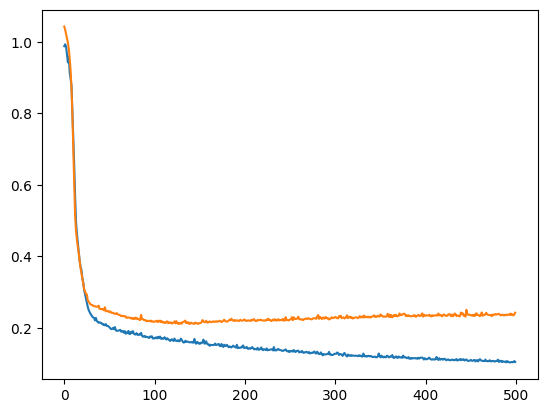

In [8]:
torch.manual_seed(42)
lr = .01
input_dim = x_train.shape[1]
normal_model = ManualRegresion(input_dim).to(device)
optimizer = optim.SGD(normal_model.parameters(), lr = lr)
loss_fn = nn.MSELoss()
n_epochs = 500
train_losses = []
val_losses = []

for epoch in range(n_epochs):
  train_loss = train(normal_model,train_loader,optimizer, loss_fn)
  train_losses.append(train_loss)
  val_loss = validate(normal_model, test_loader, loss_fn)
  val_losses.append(val_loss)
  if (epoch + 1) % 50 == 0 or epoch == 0:
    print(f'Epoch {epoch + 1}: train loss = {train_loss}, val loss = {val_loss}')

plt.plot(range(n_epochs), train_losses)
plt.plot(range(n_epochs), val_losses)
plt.show()

In [16]:
normal_model.eval()
with torch.no_grad():
  y_pred = normal_model(torch.tensor(x_test.values , dtype=torch.float32).to(device))
  y_pred = y_pred.cpu().numpy()

y_pred_rescaled = y_scaler.inverse_transform(y_pred)
y_test_rescaled = y_scaler.inverse_transform(y_test)

MSE = mean_squared_error(y_test_rescaled , y_pred_rescaled)
MAE = mean_absolute_error(y_test_rescaled , y_pred_rescaled)
MAPE = mean_absolute_percentage_error(y_test_rescaled , y_pred_rescaled)
r2 = r2_score(y_test_rescaled , y_pred_rescaled)

print("MSE : ", MSE)
print("MAE : ", MAE)
print("MAPE : ", MAPE)
print("r2 : " ,r2)

MSE :  210394663405324.2
MAE :  10826183.203506544
MAPE :  0.12997307126246516
r2 :  0.7656010922578633


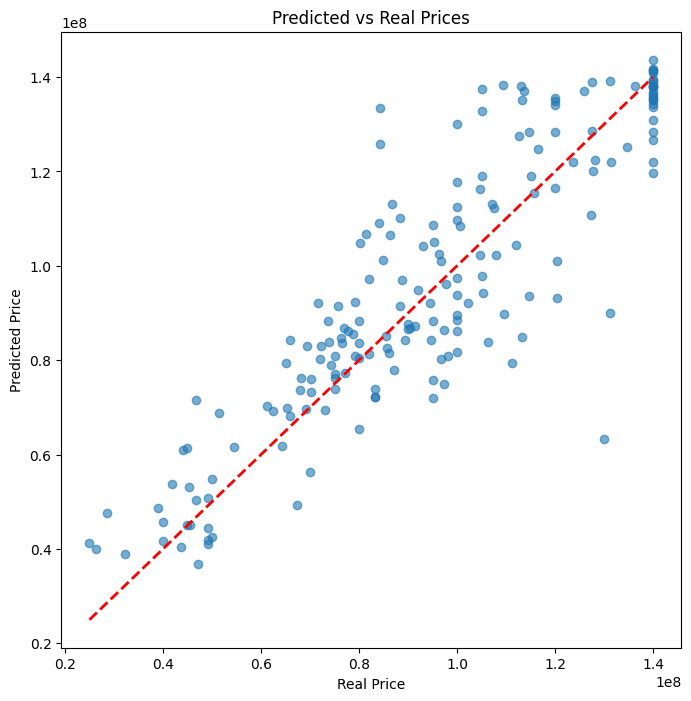

In [17]:
plt.figure(figsize=(8,8))
plt.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.6)
plt.plot([y_test_rescaled.min(), y_test_rescaled.max()],
         [y_test_rescaled.min(), y_test_rescaled.max()],
         color="red", linestyle="--", linewidth=2)
plt.xlabel("Real Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Real Prices")
plt.show()

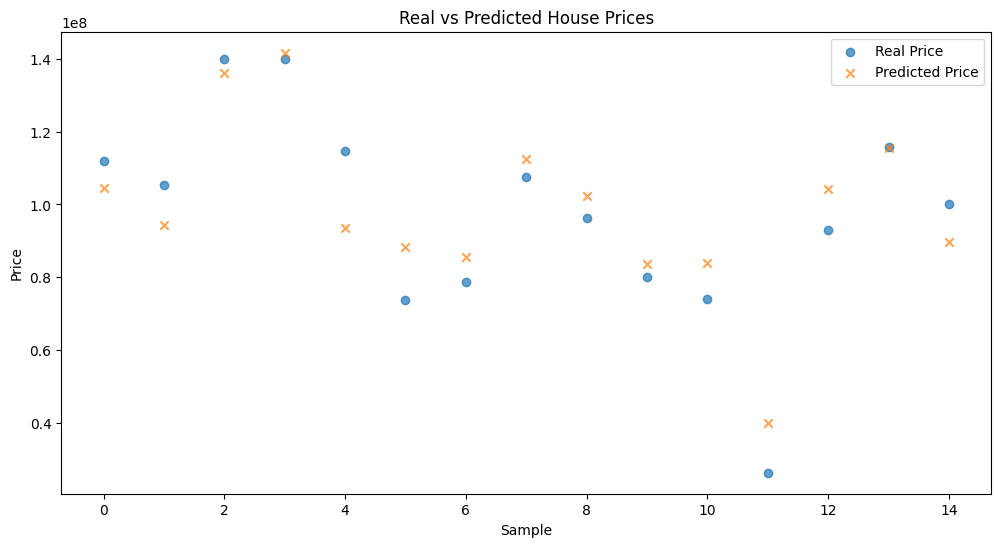

In [18]:
# np.random.seed(42)
rand_idx = np.random.randint(0,len(y_test_rescaled),(15,))
plt.figure(figsize=(12,6))
plt.scatter(range(15), y_test_rescaled[rand_idx], label="Real Price", alpha=0.7, marker='o')
plt.scatter(range(15), y_pred_rescaled[rand_idx], label="Predicted Price", alpha=0.7, marker='x')
plt.title("Real vs Predicted House Prices")
plt.xlabel("Sample")
plt.ylabel("Price")
plt.legend()
plt.show()